<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day Day 23: Free Form Deformation"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 25, April 01, 2019</h4>

In [3]:
from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from IPython.display import HTML
import io
import base64

import SimpleITK as sitk
import registration_utilities as ru
import registration_callbacks as rc
import utilities as util

from ipywidgets import interact, fixed

#utility method that either downloads data from the MIDAS repository or
#if already downloaded returns the file name for reading from disk (cached data)
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

OUTPUT_DIR = "output"

## Objective

Free Form Deformation (FFD) using B-splines.

Previously, we learnt about one form of deformable registration using Thin Plate Splines. The idea was to identify two set of homologous landmarks from each of the **moving** and **fixed** image, and used the position of these landmarks as the basis for registration.

There are two components to the TPS deformable registration: first is the (global) affine registration, followed by a (local) deformable registration.  The local deformation is governed by minimzing a bending energy.

TPS(Thin Plate Splines) registration does **not** take into account the image characteristics, such as pixel intensity and histogram, at all.

A quick review.

### TPS Registration Applications

Image Registration
* *With point matching*: [**Registration of images with geometric distortions** by A. Goshtasby, *IEEE Transactions on Geoscience and Remote Sensing*, 26(1):60-64, 1998](http://ieeexplore.ieee.org/document/3000/).
* *With voxel similarity measures*: [**Demonstration of accuracy and clinical versatility of mutual information for automatic multimodality image fusion using affine and thin-plate spline warped geometric deformations** by Meyer et al., *Medical Image Analysis*, 1(3):195-207, 1997](https://www.sciencedirect.com/science/article/pii/S1361841597850104)


#### Advantage:

Control points can have arbitrary spatial distribution:
  * In theory, choose as many as you like,
  * But registration accurady depends on how well these landmarks can be determined, i.e. Fiducial Localization Error (FLE)
  * More landmarks means more parameters to determine,
  
#### Disadvantages:
* Requires point matching, $1:1$ correspondence
  * which requires manual work,
  * and expertise (medical images == medical expertise)
* Control points have global influence since the use of basis function has infinite support!
  * it *cannot* handle local distortion effectively
  * see [**Radial basis functions with compact support for elastic registration of medical images** by Fornefett, Rohr, and Stiehl, *Image and Vision Computing*, 19(1-2):87-96, 2001](https://www.sciencedirect.com/science/article/pii/S0262885600000573)

The properties of the radial basis function, that it has an infinite support, means that moving a single landmark has a global effect to all pixels in the image. Sometimes this property is not desired.

For example, suppose we are performing a deformable registration of two images containing both bones and soft tissues. Bone is considered as a rigid structure and does not deform as a single object (bones connected by a joint may deform/bend). Thus, if we use TPS to register these images and defined landmarks on the deformable soft tissues, the "rigidity" of the bone is affected even if the chosen landmarks are far away.

Some of these properties are further explored in *Assignment $4$*.

#### Point Registration with TPS

(In $2D$, generalize it to $3D$ youself accordingly. Think about how many parameters are needed in both cases.)
* For $N$ pairs of points $(x,y) \rightarrow (x',y')$,
* Find the $6+2N$ coefficients

$a_{1,1}, a_{2,1}, a_{3,1}, w_{j,1},a_{1,2}, a_{2,2}, a_{3,2}, w_{j,2}$, such that


$
\begin{eqnarray}
x' & = & a_{1,1} + a_{2,1} x + a_{3,1} y + \sum_{j=1}^n w_{j,1} U(|(x_j,y_j)-(x,y)|)\\
y' & = & a_{1,2} + a_{2,2} x + a_{3,2} y + \sum_{j=1}^n w_{j,2} U(|(x_j,y_j)-(x,y)|)\\
\end{eqnarray}
$

for all $N$ pairs ($2N$ equations), and 

* also satisfy these $6$ equations:

$
\begin{eqnarray}
  \sum w_{j,1} & = & 0\\
  \sum w_{j,2} & = & 0\\
  \sum w_{j,1} x_j & = & 0\\
  \sum w_{j,2} x_j & = & 0\\
  \sum w_{j,1} y_j & = & 0\\
  \sum w_{j,2} y_j & = & 0\\
\end{eqnarray}
$

* After these coefficients are found, use them to compute $(x',y')$ for every point $(x,y)$ in the image.

**Questions**: What is $U$ in $2$D and $3$D?

#### Why does TPS behave well?

As a point $x$ moves away from the $N$ fiducial points, the term in the sum

(in $2$D. **Question**: What is the equivalent equation in $3$D?)

$
\sum_j^N w_{j,1} r^2 \log( r^2)
$

begin to cancel out. The sum $\to 0$. The same thing happens to $y$-axis, so

$
\begin{eqnarray}
x' & \to & a_{1,1} + a_{2,1} x + a_{3,1} y\\
y' & \to & a_{1,2} + a_{2,2} x + a_{3,2} y
\end{eqnarray}
$

which is an *affine* registration.

### Example

Since we will be implementing TPS in Assignment 4, we will use VTK's implementation for this numerical example. If you have downloaded 3D Slicer previously (instruction in Day 22's notes), enter the following python codes in Slicer's Python intepreter.

(for now, we are using the simple examples of TPS as outlined in Day 22's notes, i.e. making a sad orangutan)

```python

# Assume 2D points, z=0, although VTK's implementation works for 3D TPS.
#
# If using 3D TPS, one needs to set the basis function to R insteadl of R^2 log(R^2)
#
# transform.SetBasisToR()
#

# image size, we need to flip the y-axis
imagex = 800
imagey = 600

p1.SetNumberOfPoints( 5 )
p1.SetPoint( 0, 324,  imagey-499, 0) # right point on the lip,  y = 101
p1.SetPoint( 1, 378,  imagey-540, 0) # center point on the lip, y = 60
p1.SetPoint( 2, 451,  imagey-510, 0) # left point on the lip,   y = 90
p1.SetPoint( 3, 343,  imagey-234, 0) # right eye                y = 366
p1.SetPoint( 4, 452,  imagey-229, 0) # left eye                 y = 371

p2.SetNumberOfPoints( 5 )
p2.SetPoint( 0, 324,  imagey-540, 0) # right point on the lip   y = 60
p2.SetPoint( 1, 378,  imagey-540, 0) # center point on the lip  y = 60
p2.SetPoint( 2, 451,  imagey-540, 0) # left point on the lip    y = 60
p2.SetPoint( 3, 343,  imagey-234, 0) # right eye                y = 366
p2.SetPoint( 4, 452,  imagey-229, 0) # left eye                 y = 371

   
transform = vtk.vtkThinPlateSplineTransform()
transform.SetSourceLandmarks( p1 )
transform.SetTargetLandmarks( p2 )
transform.SetBasisToR2LogR()         # use transform.SetBasisToR() for 3D
transform.Modified()
```

**Question**: Where are the control points themself mapped to?

```python
# one of the control point, assuming z=0
transform.TransformPoint([324, 101, 0]) # left point on the lip
```

**Question**: What about a pixel that is far far away?

```python
# a pixel that is far far away, assuming z=0
transform.TransformPoint([8000, 6000, 0])
```

**Question**: What about a pixel located close to the control point?

```python
# a pixel that is near by the control points
transform.TransformPoint([400, 300, 0])
```

#### Displacement field

By transforming $(x,y)\to (x',y')$, we can conceptualize it as:

<img src="deform.PNG" style="width:400px"/>

That is, we *displace* a pixel by moving it to a new location. For all pixels, this can be visualized as a *displacement field*:

<img src="displacement_fields.PNG" style="width:400px"/>

<img src="LenaDeform.PNG" style="width:600px"/>
<img src="Deformable_grid.PNG" style="width:400px"/>
<img src="deformation_field.PNG" style="width:800px"/>
Image courtesy of Loren Author Schwarz, 2007.

#### Forward mapping versus Backward mapping

Given the definition of a displacement field, there are two principal ways of how an image warping can be accomplished:

**Forward Mapping**

$
I'_{m}(T(x)) \leftarrow I_{m}(X), \forall x \in \Omega,
$

This is referred to as the *forward* warping: pixels from the **Reference** image is *forwarded* from the coordinate frame of the reference image to the new image. One may come up with some pseudo-code for doing so:

``` python
for i in range(0, umax):
  for j in range(0, vmax):
    x = X(u,v)
    y = Y(u,v)
    newImage[round(X(u,v)), round(Y(u,v))] = referenceImage[u,v]
```

<img src="forward_mapping.png" style="width:600px"/>

The function pair $[X(),Y()]$ defines what is known as a *forward map* from the reference image to new (warped) image. Note that the $round()$ operations in the assignment statement are necessary to provide integer pixel coordinates. If the reference image were continuous, and the forward map is reasonably smooth (i.e. it had no discontinuities), it would suffice to allow one to *paint in* the warped image from the reference image. That is, for each coordinate pair (u,v) in the reference image, we would simply color the point $[X(u,v), Y(u,v)]$ in the warped image the same colour as the point $(u,v)$ in the reference image.

The fundamental problem is that we are working with **digital** image, meaning that the image/volume we get is a discrete samples of the original continuous signal. The implication is that, in general, the warp function will not map continuously-indexed pixels in the reference image to continuously-indexed pixels in the new image:


<img src="forward_warping.png" style="width:600px"/>

There are potentially several problems in the Forward Warping approach:
* Same source pixel may map to multiple destination pixels, where the output is scaled down with respect to the reference,
* Some destination pixels may have no corresponding source, i.e. leaving holes in the new image, where the output is scaled up compared with the input,

The fundamental problem is that each pixel in the reference (input) image represents a finite (non-zero) area and actually projects an area of the reference image onto the output, as shown below:

<img src="pixel_project.png" style="width:600px"/>

If the forward mapping algorithm carefully projects each pixel onto the output, we would see that each input pixel *might* fully cover some output pixels and partially cover several other output pixel, or it *might* only partially cover a single pixel. To construct a proper output image, we could calculate the percentage coverage of each output pixel by the input pixel, and use it to compute a weighted average pixel intensity/color for each output pixel. This would give us an warped/output image without holes or overlaps.

But the calculation of the correct percentage/weights could get very complex, especially if the forward map is highly non-linear (i.e straight light gets mapped to a curved line):
* if the mapping is linear, a simple way to do the forward projection of a pixel is to map each of its four corners and then connect these projected corners by straight lines,
* if the mapping is non-linear, one would have to resort to other methods to get accurate results,
    - such as mapping many sample points around the pixel contour.
   
Either way, these methods are bound to be slow to computer and hard to implement.

If the forward mapping is highly non-linear,

* and there would be a *fold* problem as well:

<img src="foward_warp_problem.PNG" style="width:800px"/>
image courtesy of [here](http://groups.csail.mit.edu/graphics/classes/CompPhoto06/html/lecturenotes/14_WarpMorph.pdf)

**Inverse Warping/Mapping**

The other option that eliminates these problem is the **inverse** warping. The main difference is that now for every pixel of the new image, a coodrinate in the original (reference) image is computed, where its intensity value originates from. This involves the inverse transformation $T^{-1}$:

$
I'_{m}(x) \leftarrow(T^{-1}(x)), \forall x \in \Omega,
$

In analogy to forward warping, it is possible that $T^{-1}(x)$ yields a non-integer value. However, we can easily apply an interpolation scheme on the original (reference) image to obtain intensity values at coordinates between systems. (Since the reference image is on a regular grid, interpolation in general works fine). 

Unfortunately the inverse of the transformation function is often not trivial to obtain. However, in many cases an approximation such as the following can be used with acceptable results:

$
T^{-1}(x) \approx x-u(x)
$

As a matter of definition, the behavior of the transformation function can be treated as an inverse, so that an actual inversion would only be required for forward warping.

<img src="foward_inverse_warping.PNG" style="width:800px"/>
Image courtesy of Loren Author Schwarz, 2007.


That is, instead of sending each input pixel to an output pixel, we look at each output pixel and determine what input pixel(s) map to it, as shown below.

<img src="inverse_warping.PNG" style="width:800px"/>

The inver mapping function can be defined as:

$u = U(x,y)$

$v = V(x,y)$

such that

$u = U[X(u,v), Y(u,v)]$

$v = V[X(u,v), Y(u,v)]$

In other words, the function pair $[U(),V()]$ is chosen such that it should exactly inverts (un-do) the mapping due to the pair $[X(),Y()]$. Thus, if one samples the output image at oint $(x,y)$, then $(u,v)=[U(x,y),V(x,y)]$ gives the coordinate $(u,v)$ in the input/reference image that map to position $(x,y)$ in the output. As in the forward mapping, one would need to **round** the inverse mapping to give integer pixel coordinates, but keep in mind that we are roudning the coordinates in the *input/reference* (which is **rectilinear**) and not in the output image (which is **warped**). The inverse warping algorithm is simply:

``` python
for i in range(0, xmax):
  for j in range(0, ymax):
    u = U(x,y)
    v = Y(x,y)
    newImage[x,y] = referenceImage[round(U(x,y)),round(V(x,y))]
```

Thus, even with a sampled digital image, we can compute the output image from the input image using the inverse warping, without fear of holes or overlaps in the output image.

One disadvantage of the inverse mapping is that it may over-sample the original (Reference) image, resulting in an **aliasing artifacts**, or under-sample the original image, resulting in an **reconstruction artifacts** (leading to staircasing effects).

<img src="resampling_aliasing.png" style="width:800px"/>
image courtesy [here](http://groups.csail.mit.edu/graphics/classes/CompPhoto06/html/lecturenotes/14_WarpMorph.pdf)

But in general, the advantage of the inverse warping over the forward warping are:
* no holes
* simplier/easier to implement.

### Free Form Deformation (FFD) Transformation

First off, FFD Transformation and registration are based on the following two papers (available on OWL):

[Lee, Wolberg, and Shin,
**Scattered data interpolation with multilevel B-splines**,
*IEEE Transactions on Visualization and Computer Graphics*,
(3)3:228-244, 1997](http://ieeexplore.ieee.org/abstract/document/620490/), and

[Rueckert et al.,
**Nonrigid registration using free-form deformations: application to breast MR images**,
*IEEE Transactions on Medical Imaging*,
18(8):712-721, 1999](http://ieeexplore.ieee.org/document/796284/)

Consider this mentally exercise:
* Suppose we overlay a grid on top of the image,
* The image is assumed to be *locally* elastic,
* By moving one node the image will deform as shown:
<img src="local_deform.PNG" style="width:400px"/>
* By moving around a select set of **control points**, a new image can be produced. Consider the control points motion as the deformation,
* Following this mental exercise, can we find a transformation that turns a moving image the most similar to its fixed image?   

Differ from TPS, this *local elasticity* means that changing the position of the control point only has local effect: pixels far away from the deformed grid are not effected.

#### FFD Intensity-based Registration workflow

The popular feee-form deformation (FFD) registration approach characterizes deformation based on a grid of control points. B-splines serve the purpose of interpolating the dense deformation field from a given control point configuration. the central idea is to combine the FFD methods with well-understood techniques intensity-based registration framework. The basic workflow is to:


<img src="BSpline_Subdivision.PNG" style="width:900px"/>

* Solve for an optimal affine transformation paramether $\Theta$ between two images/volumes by maximizing a measure of similarity metric,
* initialize the control points $\Phi$ by laying a uniform $3$D mesh of control points through the image/volume,
* Deform the image iteratively by moving the control points,
  * Control point motion is primary transformation parameters,
  * Pixels will follow control points using a spline function
* Calculate NMI (or any other suitable metric) and through optimization stop when it is maximum,
* increase the control point resolution.
* How is pixel motion calculated using moved control point?
  
But let us take a look at interpolation using B-spline first.

#### Interpolation using B-spline

Image courtesy of Lee, Wolberg, and Shin (IEEE TVCG, 1997)
<img src="bSpline_face.PNG" style="width:600px"/>

Another type of deformable, point-based, registration is B-splines deformation. It was initially introduced as a way to interpolate scattered data. It is actually not often used to register image itself, but rather, just deforms and image and provide a way to interpolate the pixels between control points. Later, it is incorporated into an *intensity* based image registration by using grid/lattice as control points.

It is, however, used quite often in the entainmen industry:
[![test](T888_vs_Weaver.PNG)](https://www.youtube.com/watch?v=1txB3x72MeU)

#### Medical Example

In Breast Cancer Imaging using MRI, in order to differentiate tissue types in MRI, a contrast agent is often injected into the tissue. One side benefit of such an injection is that because the contrast is enhanced, it enhances image registration.

As it often takes time for the contrast agent to infuse into (wash-in), and out of (wash-out), the MRI images taken at different time will have different appearances:

<img src="breast_contrast_time.PNG" style="width:800px"/>

* A sequence of MRI images are acquired where changes of brightness of abnormal area is monitored over time,
* Contrast wash-in and wash-out characterization can determine whether the inclusion is a malignant tumor or benign lesion (e.g. fast wash-in and wash-out may indicate malignancy),
* Requires image registration to ensure that the same area is being monitored over time.

**Question**: As contrast is changing across the time series, what would you choose as the image similarity metric?

#### Free Form Deformation Based Non-Rigid Registration

[Lee, Wolberg, and Shin,
**Scattered data interpolation with multilevel B-splines**,
*IEEE Transactions on Visualization and Computer Graphics*,
(3)3:228-244, 1997](http://ieeexplore.ieee.org/abstract/document/620490/),

introduced the concept of using B-Splines to interpolate scattered data. FFD is a common technique in computer graphics for modelling $3$D deformable objects.

* FFDs are defined by a mesh of control points with uniform spacing,
* FFDs deform an underlying object by manipulating a mesh of control points:
  * control point can be displaced from their original location,
  * control points provide a parameterization of the transformation
* Typical a cubic B-splines are used:

$
\begin{eqnarray}
B_{0}(u) & = & (1-u)^3/6\\
B_{1}(u) & = & (3 u^3 - 6 u^2 + 4)/6\\
B_{2}(u) & = & (-3 u^3 + 3 u^2 + 3 u + 1)/6\\
B_{3}(u) & = & u^3/6\\
\end{eqnarray}
$

Although once understood, other types of B-splines can be used.

In [4]:
def b0(u):
    return( (1-u)**3 / 6)
def b1(u):
    return( (3*u**3 - 6*u**2 + 4) / 6)
def b2(u):
    return( (-3*u**3 + 3*u**2 + 3*u + 1) / 6)
def b3(u):
    return( u**3 / 6)

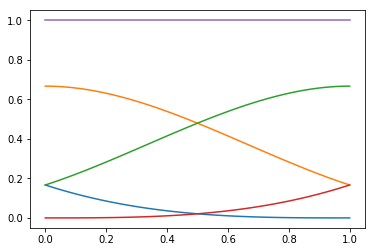

In [5]:
n = 101
x = np.linspace(0, 1, n)
b = np.zeros([4,n])
for y in range(0,n):
    b[0,y] = b0(x[y])
    b[1,y] = b1(x[y])
    b[2,y] = b2(x[y])
    b[3,y] = b3(x[y])
    
plt.plot(x,b[0,:], x,b[1,:], x,b[2,:], x,b[3,:], x,(b[0,:]+b[1,:]+b[2,:]+b[3,:]))

Notice the $5{th}$ line (purple), which is the sum of all $4$ bases functions, is $1$ **always**.

One interesting thing about cubic spline, which is appearent after re-arranging them, is that they can be joint to form a smooth curve. The point where they join, $([-8,0,8])$, are called **knots**, where two of the basis functions have the same values. The end-points $([-16,16])$ are evaluated to $0$.

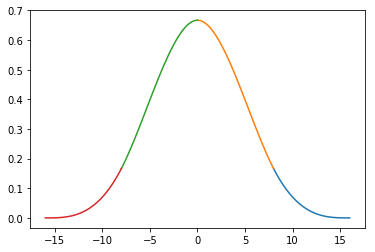

In [6]:
plt.plot(8*x+8,b[0,:], 8*x,b[1,:], 8*x-8,b[2,:], 8*x-16,b[3,:])

These four polynomial piece meet at the same values such that the resulting spline is continuous across each knot. In addition, the slopes are the same: the first derivative is continuous across each knot. 

While it is not as clear from this figure, the second derivatives are also equal at the knots (derive it yourself!), so the cubic B-spline
* is continuous,
* has continuous $1^{st}$ derivative, and
* has continuous $2^{st==nd}$ derivative, and

These properties ensur that functions based on these splines will not make sudden changes that will result in warping for which there is a *tear* or a *kink*.

### Other B-splines

For completness, other B-splines of degree 0, 1, 2 (and 3) are:

#### piece-wise
$
\begin{eqnarray}
B_{0}(u) & = & 1, \text{if $u_i <= u < t_{i+1}$}\\
& = & 0, \text{otherwise}
\end{eqnarray}
$

#### Linear
$
\begin{eqnarray}
B_{0}(u) & = & 1-u\\
B_{1}(u) & = & u
\end{eqnarray}
$

#### Quadratic

$
\begin{eqnarray}
B_{0}(u) & = & u^2/2\\
B_{1}(u) & = & (-2 u^2 + 2 u + 1)/2\\
B_{2}(u) & = & (u^2 - 2 u + 1)/2
\end{eqnarray}
$

#### Cubic

$
\begin{eqnarray}
B_{0}(u) & = & (1-u)^3/6\\
B_{1}(u) & = & (3 u^3 - 6 u^2 + 4)/6\\
B_{2}(u) & = & (-3 u^3 + 3 u^2 + 3 u + 1)/6\\
B_{2}(u) & = & u^3/6\\
\end{eqnarray}
$

#### Interpolating ($1$D) with B-Splines

The reason to use B-Splines to represent deformation is because it provides a smooth interpolation, and can be easily extended to $N$-D.  Consider the following fitting problem. The basic idea is that we can approximate a sparse-sampled signal using interpolation. Using a higher degree of polynomial implies smoother interpolation.

<img src="interpolate1.PNG" style="width:600px"/>
<img src="interpolate2.PNG" style="width:600px"/>
<img src="interpolate3.PNG" style="width:600px"/>
<img src="interpolate4.PNG" style="width:600px"/>
<img src="interpolate5.PNG" style="width:600px"/>
<img src="interpolate6.PNG" style="width:600px"/>
<img src="interpolate7.PNG" style="width:600px"/>
<img src="interpolate8.PNG" style="width:600px"/>
<img src="interpolate9.PNG" style="width:600px"/>
<img src="interpolate10.PNG" style="width:600px"/>
<img src="interpolate11.PNG" style="width:600px"/>
<img src="interpolate12.PNG" style="width:600px"/>
<img src="interpolate13.PNG" style="width:600px"/>
<img src="interpolate14.PNG" style="width:600px"/>
<img src="interpolate15.PNG" style="width:600px"/>
<img src="interpolate16.PNG" style="width:600px"/>
image adapted from ITK.

#### Cubic B-Splines in $2$D

To extend the B-Splines in $2-$ or $3-$D, one only needs to specify a set of Cubic B-Splines for each axis.

<img src="cb2d1.PNG" style="width:600px"/>
<img src="cb2d2.PNG" style="width:600px"/>
<img src="cb2d3.PNG" style="width:600px"/>

Then

<img src="cb2d4.PNG" style="width:600px"/>
<img src="cb2d5.PNG" style="width:600px"/>
<img src="cb2d6.PNG" style="width:600px"/>
<img src="cb2d7.PNG" style="width:600px"/>
<img src="cb2d8.PNG" style="width:600px"/>

To apply B-Spline deformation, we first overlay a BSplines Grid with the image:

<img src="cb2d9.PNG" style="width:600px"/>
<img src="cb2d10.PNG" style="width:600px"/>
<img src="cb2d11.PNG" style="width:600px"/>
<img src="cb2d12.PNG" style="width:600px"/>
<img src="cb2d13.PNG" style="width:600px"/>

That is, because we are using Cubic B-Splines, our B-Spline grid has to be larger than the image grid.  Let us illustrate it with a numerical example.

#### Interpolation Using B-Splines
<img src="Interpolation1.PNG" style="width:600px"/>
<img src="Interpolation2.PNG" style="width:600px"/>
<img src="Interpolation3.PNG" style="width:600px"/>
<img src="Interpolation4.PNG" style="width:600px"/>
<img src="Interpolation5.PNG" style="width:600px"/>

#### Free Form Deformation


So how is this deformation accomplished?

<img src="cb2d12_arrow.PNG" style="width:600px"/>

Imaging the original image has a grid overlayed, and the displacement of a control point is denoted by a vector $(dx,dy)$. Let us define the following terms so we can work out the math:

* $\Omega$ - the image, rectangular, domain
* $(x,y)$ - index to the image (in $2$D), thus
  * $\Omega = {(x,y) | 0 \le x < m, 0 \le y < n}$,
  * $m$, and $n$ are the number of pixels in the respective axis,
* $\Phi$ - the control lattice overlaid on the domain $\Omega$.
  * If the spacing of $\Phi$ is $1$, then $\Phi$ is an $(m+3)\times (n+3)$ lattice which spans the integer grid in $\Omega$:
<img src="controlLattice.PNG" style="width:400px"/>
* Let $\phi{ij}$ be the value of the $ij^{th}$ control point on lattice $\Phi$ located at $(i,j)$ for $i=-1,0,\cdots,m+1$ and $j=-1,0,\cdots,n+1$, then the approximation function $f$ is defined in terms of these control points by

$
f(x,y) = \sum_{k=-1}^2 \sum_{l=-1}^2 B_{k}(s) B_{l}(t) \phi_{(i+k)(j+l)}
$
where
  * $i = \lfloor x \rfloor -1$,
  * $j = \lfloor y \rfloor -1$,  
  * $s = x - \lfloor x \rfloor $,
  * $t = y - \lfloor y \rfloor $,
  * $B_{k}$ and $B_{l}$ are uniform cubic B-spline basis functions (defined above already, but re-defined here with different subscript):

$
\begin{eqnarray}
B_{-1}(t) & = & (1-t)^3/6\\
B_{0}(t) & = & (3 t^3 - 6 t^2 + 4)/6\\
B_{1}(t) & = & (-3 t^3 + 3 t^2 + 3 t + 1)/6\\
B_{2}(t) & = & t^3/6\\
\end{eqnarray}
$

where $0 \le t < 1$. They serve to weight the contribution of each control point to $f(x,y)$ based on its distance to $(x,y)$.

**IF** the spacing between control point is greater than $1$, then we need to modify the index. Assume the spacing is $\delta_x$ in the $x$-axis and $\delta_y$ in the $y$-axis, then
$
\begin{eqnarray}
i & = &\lfloor \frac{x}{\delta_x} \rfloor -1\\
j & = &\lfloor \frac{y}{\delta_y} \rfloor -1\\
s & = & \frac{x}{\delta_x} - \lfloor \frac{x}{\delta_x} \rfloor\\
t & = & \frac{y}{\delta_y} - \lfloor \frac{y}{\delta_y} \rfloor\\
\end{eqnarray}
$

That is, $(s,t)$ specifies the *local* coordinate of a point with respect to the control lattice, and $(i,j)$ is the index to the control points on the lattice.
<img src="FFD_coord.PNG" style="width:400px"/>
<img src="FFD_local_coord.PNG" style="width:400px"/>

#### Numerical Example

A regular grid of control points with equal spacing of $10$mm in both of $x$ and $y$ directions is shown in the following figure where the control points are labelled from $1$ to $16$:
<img src="FFD_example1.PNG" style="width:300px"/>

This grid is laid over an image to perform image registration using FFD with cubic B-Splines. Assume that in one iteration, only control points $6$, $7$, $10$, and $11$ moved from the current coordinates as follows while the coordinates of all other control points remain unchanged:
* Point 6: from $(20,20)$ to $(17.5,17.5)$
* Point 7: from $(30,20)$ to $(27.5,22.5)$
* Point 10: from $(20,30)$ to $(22.5,27.5)$
* Point 11: from $(30,30)$ to $(35,35)$

Where is the new coordinate of point $C(25,25)$ located in the centre of the grid?

In [19]:
# first of, calculate all indices
x = 25
y = 25
dx = 10
dy = 10
i = np.floor(x/dx)-1
j = np.floor(y/dy)-1
u = x/dx - np.floor(x/dx)
v = y/dy - np.floor(y/dy)
#floor  是用来取底的
print(u,v,i,j,np.floor(5/3))

0.5 0.5 1.0 1.0 1.0


In [17]:
# evaluate the basis functions
Bu = np.array([b0(u), b1(u), b2(u), b3(u)])
Bv = np.array([b0(v), b1(v), b2(v), b3(v)])
print(Bu)
print(Bv)
Buv = np.reshape(Bu,[4,1])*Bv 
print(Buv) # 4x4
Buv = np.reshape(Buv,[1,16]) 
print(Buv) # 1x16

[0.02083333 0.47916667 0.47916667 0.02083333]
[0.02083333 0.47916667 0.47916667 0.02083333]
[[0.00043403 0.00998264 0.00998264 0.00043403]
 [0.00998264 0.22960069 0.22960069 0.00998264]
 [0.00998264 0.22960069 0.22960069 0.00998264]
 [0.00043403 0.00998264 0.00998264 0.00043403]]
[[0.00043403 0.00998264 0.00998264 0.00043403 0.00998264 0.22960069
  0.22960069 0.00998264 0.00998264 0.22960069 0.22960069 0.00998264
  0.00043403 0.00998264 0.00998264 0.00043403]]


In [12]:
# define the displacement vectors
displacements = np.zeros([16,2])
displacements[ 5,:] = [-2.5, -2.5]
displacements[ 6,:] = [-2.5,  2.5]
displacements[ 9,:] = [ 2.5, -2.5]
displacements[10,:] = [ 5,    5]
print(displacements)

[[ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [-2.5 -2.5]
 [-2.5  2.5]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 2.5 -2.5]
 [ 5.   5. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]


In [13]:
disp = np.matmul(Buv,displacements)

print('The displacement vector is ', disp)
print('The new coordinates of the point C(25,25) is (',x+disp[0,0], ',', y+disp[0,1],')')

The displacement vector is  [[0.57400174 0.57400174]]
The new coordinates of the point C(25,25) is ( 25.57400173611111 , 25.57400173611111 )


Note that in order to deform a given point, we need a neighbourhood of $4\times 4$ control points. This is because the Cubic B-Splines were used.

**Exercise**:  Change these displacement vectors artificially and examine the behaviour. Does a displaced control point always go to where you think it should?

### Nonrigid Registration Using FFD

Now we understood how to use FFD with B-Spline to deform an image, we can examine how to use it for non-rigid registration. The paper:

[Rueckert et al.,
**Nonrigid registration using free-form deformations: application to breast MR images**,
*IEEE Transactions on Medical Imaging*,
18(8):712-721, 1999](http://ieeexplore.ieee.org/document/796284/)

is perhaps the first paper in the medical domain that incorporated FFD with an image similarity metric for image registration. The deformable transformation they seek is:

$
T(x,y,z) = T_{\text{global}}(x,y,z) + T_{\text{local}}(x,y,z)
$

where $T_{\text{global}}$ is the affine transformation:

$
T_{\text{global}}(x,y,z) = \begin{pmatrix}
\theta_{11} & \theta_{12} & \theta_{13} \\
\theta_{21} & \theta_{22} & \theta_{23} \\
\theta_{31} & \theta_{32} & \theta_{33} \\
\end{pmatrix}
\begin{pmatrix}
x\\y\\z\end{pmatrix} +\begin{pmatrix}
\theta_{14}\\\theta_{24}\\\theta_{34}\end{pmatrix}
$

where the affine coefficients are denoted as $\Theta$.

The local transform is the deformation as defined by the control points. Denote $\Phi$ as the $n_x \times n_y \times n_z$ lattice of control points $\theta_{i,j,k}$ with uniform spacing $\delta$, then the local transform is the FFD written as the $3$D tensor product of the $1$D cubic B-Splines:

$
T_{\text{local}}(x,y,z) =
\sum_{l=0}^3 \sum_{m=0}^3 \sum_{n=0}^3
B_{l}(u) B_{m}(v) B_{n}(w) \theta_{i+l,j+m,k+n}
$

where

$
\begin{eqnarray}
i  & = & \lfloor \frac{x}{\delta} \rfloor -1 \\
j  & = & \lfloor \frac{y}{\delta} \rfloor -1 \\
k  & = & \lfloor \frac{z}{\delta} \rfloor -1 \\
u & = & \frac{x}{\delta} - \lfloor \frac{x}{\delta} \rfloor\\
v & = & \frac{y}{\delta} - \lfloor \frac{y}{\delta} \rfloor\\
w & = & \frac{z}{\delta} - \lfloor \frac{z}{\delta} \rfloor\\
\end{eqnarray}
$

**Note**: even though in the paper by Rueckert et al. they assumed uniform spacing $\delta$, it is not strickly required. In practice, however, $\delta$ is set to $2^a$, such that a finer control point lattice can be divided/derived easily.

The control points $\Phi$ acts as parameters of the B-Spline FFD and the degree of non-rigid deformation which can be modelled depends on the resolution of the mesh of the control oints $\Phi$:
* A large $\delta$ allows modelling of global non-rigid deformations,
* A small $\delta$ allows modeling of highly local non-rigid deformation,
* However, $\delta$ defines the DoF!
  * A B-Spline FFD defined by a $10\times 10\times 10$ mesh of control points yields a transformation with $3,000$ DoF.
* Thus, a hierarchical multi-resolution approach is often used where one starts with a coarse grid; when no further deformation is achieved, the grid is sub-divided into finer grid to model further local deformations.
  * hence $\delta$ is often set to $2^a$.

#### Similarity metric

While in this paper the Mutual Information (MI) is used as the similarity metric:

$
C_{\text{similarity}}(A,B) = \frac{H(A)+H(B)}{H(A,B)}
$

In SimpleITK we can use any similarity metric. One reason MI was used in this paper is because the changing of image contrast due to the injection of contrast agent into the breast tissue. Other metrics such as SSD will not work in this case.

Define a cost function:

$
C(\Theta,\Phi) = -C_{\text{similarity}}(I(t_0), T(I(t))) + \lambda C_{\text{smooth}}(T)     ::C cost function
$

where $\lambda$ is a weighting factor, and $C_{\text{smooth}}$ is a panelty term that corresponds to the bending of a thin-plate of metal, which encourage smooth transformation. The term $\lambda C_{\text{smooth}}(T)$ is serves as a regularizer

#### Optimization

The deformation registartion with B-Spline FFS is perform in several stages:

- **calaulate** the optimal affine transformation parameter $\Theta$ that maximizes a similarity metric $C_{\text{Similarity}}(A,B)$,
- **initialize** the control points $\Phi$ (coarse resolution),
- **repeat**
  - **calculate** the gradient vector of the cost function with respect to the non-rigid transformation parameters $\Phi$: $\bigtriangledown C = \frac{\delta C(\Theta,\Phi)}{\delta \Phi}$
  - **while** $\parallel \bigtriangledown C\parallel > \epsilon$ 
    - **update** the control points $\Phi = \Phi+ \mu \frac{\bigtriangledown C}{\parallel \bigtriangledown C \parallel} $
    - **recalculate** the gradient vector $\bigtriangledown C$
  - **increase** the control point resolution
  - **increase** the image resolution
- **until** the finest level of resolution is reached.

<img src="BSpline_Subdivision.PNG" style="width:900px"/>

#### SimpleITK example

While this sounds complicated, in SimpleITK all we need to do is to change the type of Transform in the registration framework. 

The following notebook illustrates the use of the Free Form Deformation (FFD) based non-rigid registration algorithm in SimpleITK.

The data we work with is a $4$D ($3$D + time) thoracic-abdominal CT, the Point-validated Pixel-based Breasthing Thorax Model (POPI) model. These data consist of a set of temporal CT volumes, a set of masks segmenting each of the CTs to air/body/lung, and a set of corresponding points across the CT volume.


The POPI model is provided by the Léon Bérard Cancer Center & CREATIS Laboratory, Lyon, France. The relevant publication is:

J. Vandemeulebroucke, D. Sarrut, P. Clarysse, "The POPI-model, a point-validated pixel-based breathing thorax model",
Proc. XVth International Conference on the Use of Computers in Radiation Therapy (ICCR), Toronto, Canada, 2007.

The POPI data, and additional 4D CT data sets with reference points are available from the CREATIS Laboratory <a href="http://www.creatis.insa-lyon.fr/rio/popi-model?action=show&redirect=popi">here</a>. 

## Utilities

Load utilities that are specific to the POPI data, functions for loading ground truth data, display and the labels for masks.

In [14]:
%run popi_utilities_setup.py

## Loading Data

Load all of the images, masks and point data into corresponding lists. If the data is not available locally it will be downloaded from the original remote repository. 

Take a look at the images. According to the documentation on the POPI site, volume number one corresponds to end inspiration (maximal air volume).

In [15]:
images = []
masks = []
points = []
for i in range(0,10):
    image_file_name = 'POPI/meta/{0}0-P.mhd'.format(i)
    mask_file_name = 'POPI/masks/{0}0-air-body-lungs.mhd'.format(i)
    points_file_name = 'POPI/landmarks/{0}0-Landmarks.pts'.format(i)
    images.append(sitk.ReadImage(fdata(image_file_name), sitk.sitkFloat32)) #read and cast to format required for registration
    masks.append(sitk.ReadImage(fdata(mask_file_name)))
    points.append(read_POPI_points(fdata(points_file_name)))
        
interact(display_coronal_with_overlay, temporal_slice=(0,len(images)-1), 
         coronal_slice = (0, images[0].GetSize()[1]-1), 
         images = fixed(images), masks = fixed(masks), 
         label=fixed(lung_label), window_min = fixed(-1024), window_max=fixed(976));

Fetching POPI/meta/00-P.mhd
Fetching POPI/masks/00-air-body-lungs.mhd
Fetching POPI/landmarks/00-Landmarks.pts
Fetching POPI/meta/10-P.mhd
Fetching POPI/masks/10-air-body-lungs.mhd
Downloaded 24473600 of 24473600 bytes (100.00%)
Fetching POPI/landmarks/10-Landmarks.pts
Downloaded 727 of 727 bytes (100.00%)
Fetching POPI/meta/20-P.mhd
Downloaded 48936960 of 48936960 bytes (100.00%)
Fetching POPI/masks/20-air-body-lungs.mhd
Downloaded 24473600 of 24473600 bytes (100.00%)
Fetching POPI/landmarks/20-Landmarks.pts
Downloaded 712 of 712 bytes (100.00%)
Fetching POPI/meta/30-P.mhd
Downloaded 48936960 of 48936960 bytes (100.00%)
Fetching POPI/masks/30-air-body-lungs.mhd
Downloaded 24473600 of 24473600 bytes (100.00%)
Fetching POPI/landmarks/30-Landmarks.pts
Downloaded 713 of 713 bytes (100.00%)
Fetching POPI/meta/40-P.mhd
Downloaded 48936960 of 48936960 bytes (100.00%)
Fetching POPI/masks/40-air-body-lungs.mhd
Downloaded 24473600 of 24473600 bytes (100.00%)
Fetching POPI/landmarks/40-Landmarks

interactive(children=(IntSlider(value=4, description='temporal_slice', max=9), IntSlider(value=179, descriptio…

### Getting to know your data

While the POPI site states that image number 1 is end inspiration, and visual inspection seems to suggest this is correct, we should probably take a look at the lung volumes to ensure that what we expect is indeed what is happening.

Which image is end inspiration and which end expiration?

In [20]:
label_shape_statistics_filter = sitk.LabelShapeStatisticsImageFilter()

for i, mask in enumerate(masks):
    label_shape_statistics_filter.Execute(mask)
    print('Lung volume in image {0} is {1} liters.'.format(i,0.000001*label_shape_statistics_filter.GetPhysicalSize(lung_label)))

Lung volume in image 0 is 5.455734929689075 liters.
Lung volume in image 1 is 5.527017905172941 liters.
Lung volume in image 2 is 5.554014379499289 liters.
Lung volume in image 3 is 5.451784830895104 liters.
Lung volume in image 4 is 5.301415956621658 liters.
Lung volume in image 5 is 5.191841246039885 liters.
Lung volume in image 6 is 5.09130732168864 liters.
Lung volume in image 7 is 5.11128669632256 liters.
Lung volume in image 8 is 5.195802788867059 liters.
Lung volume in image 9 is 5.335378032491021 liters.


## Free Form Deformation

This function will align the fixed and moving images using a FFD. If given a mask, the similarity metric will be evaluated using points sampled inside the mask. If given fixed and moving points the similarity metric value and the target registration errors will be displayed during registration. 

As this notebook performs intra-modal registration, we use the MeanSquares similarity metric (simple to compute and appropriate for the task).

In [21]:
def bspline_intra_modal_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    
    return registration_method.Execute(fixed_image, moving_image)

## Perform Registration

The following cell allows you to select the images used for registration, runs the registration, and afterwards computes statistics comparing the target registration errors before and after registration and displays a histogram of the TREs.

To time the registration, uncomment the timeit magic. 
<b>Note</b>: this creates a separate scope for the cell. Variables set inside the cell, specifically tx, will become local variables and thus their value is not available in other cells. 

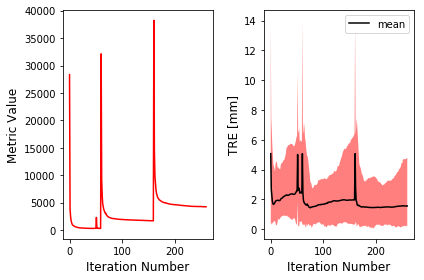

Initial alignment errors in millimeters, mean(std): 5.07(2.67), max: 14.02
Final alignment errors in millimeters, mean(std): 1.55(0.87), max: 4.78


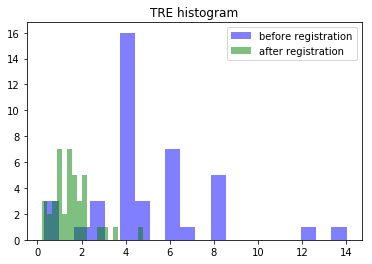

In [22]:
#%%timeit -r1 -n1

# Select the fixed and moving images, valid entries are in [0,9].
fixed_image_index = 0
moving_image_index = 7


tx = bspline_intra_modal_registration(fixed_image = images[fixed_image_index], 
                                      moving_image = images[moving_image_index],
                                      fixed_image_mask = (masks[fixed_image_index] == lung_label),
                                      fixed_points = points[fixed_image_index], 
                                      moving_points = points[moving_image_index]
                                     )
initial_errors_mean, initial_errors_std, _, initial_errors_max, initial_errors = ru.registration_errors(sitk.Euler3DTransform(), points[fixed_image_index], points[moving_image_index])
final_errors_mean, final_errors_std, _, final_errors_max, final_errors = ru.registration_errors(tx, points[fixed_image_index], points[moving_image_index])

plt.hist(initial_errors, bins=20, alpha=0.5, label='before registration', color='blue')
plt.hist(final_errors, bins=20, alpha=0.5, label='after registration', color='green')
plt.legend()
plt.title('TRE histogram');
print('Initial alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(initial_errors_mean, initial_errors_std, initial_errors_max))
print('Final alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))

Another option for evaluating the registration is to use segmentation. In this case, we transfer the segmentation from one image to the other and compare the overlaps, both visually, and quantitatively.

<b>Note</b>: A more detailed version of the approach described here can be found in the [Segmentation Evaluation notebook](34_Segmentation_Evaluation.ipynb).

In [23]:
# Transfer the segmentation via the estimated transformation. Use Nearest Neighbor interpolation to retain the labels.
transformed_labels = sitk.Resample(masks[moving_image_index],
                             不      images[fixed_image_index],
                                   tx, 
                                   sitk.sitkNearestNeighbor,
                                   0.0, 
                                   masks[moving_image_index].GetPixelID())

segmentations_before_and_after = [masks[moving_image_index], transformed_labels]
interact(display_coronal_with_label_maps_overlay, coronal_slice = (0, images[0].GetSize()[1]-1),
         mask_index=(0,len(segmentations_before_and_after)-1),
         image = fixed(images[fixed_image_index]), masks = fixed(segmentations_before_and_after), 
         label=fixed(lung_label), window_min = fixed(-1024), window_max=fixed(976));

# Compute the Dice coefficient and Hausdorff distance between the segmentations before, and after registration.
ground_truth = masks[fixed_image_index] == lung_label
before_registration = masks[moving_image_index] == lung_label
after_registration = transformed_labels == lung_label

label_overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
label_overlap_measures_filter.Execute(ground_truth, before_registration)
print("Dice coefficient before registration: {:.2f}".format(label_overlap_measures_filter.GetDiceCoefficient()))
label_overlap_measures_filter.Execute(ground_truth, after_registration)
print("Dice coefficient after registration: {:.2f}".format(label_overlap_measures_filter.GetDiceCoefficient()))

hausdorff_distance_image_filter = sitk.HausdorffDistanceImageFilter()
hausdorff_distance_image_filter.Execute(ground_truth, before_registration)
print("Hausdorff distance before registration: {:.2f}".format(hausdorff_distance_image_filter.GetHausdorffDistance()))
hausdorff_distance_image_filter.Execute(ground_truth, after_registration)
print("Hausdorff distance after registration: {:.2f}".format(hausdorff_distance_image_filter.GetHausdorffDistance()))

interactive(children=(IntSlider(value=179, description='coronal_slice', max=359), IntSlider(value=0, descripti…

Dice coefficient before registration: 0.94
Dice coefficient after registration: 0.97
Hausdorff distance before registration: 18.04
Hausdorff distance after registration: 12.51


#### Medical Examples with animation

Let us go back to the breast imaging with contrast agents:


This is an image of the breast (left) Before injection of the contrast agent, (middle) after the injection of the contrast agent, and (right) the difference between the two mages **without** registration,
<img src="FFD_breast1.PNG" style="width:800px"/>

The following images are (left) after rigid registarion, (middle) after affine registration, and (right) after nonrigid registration. The corresponding difference images are shown below.
<img src="FFD_breast2.PNG" style="width:800px"/>
<img src="FFD_breast3.PNG" style="width:800px"/>

#### NO registration

In [24]:
%%HTML
<div align="middle">
<video width="40%" controls>
      <source src="Movie_Post.m4v" type="video/mp4">
</video></div>

#### Rigid Registration

This is the **difference** image/volume after a *rigid* registration.

In [25]:
%%HTML
<div align="middle">
<video width="40%" controls>
      <source src="Movie_Rigid.m4v" type="video/mp4">
</video></div>

#### Affine Registration

This is the **difference** image/volume after a *Affine* registration.

In [9]:
%%HTML
<div align="middle">
<video width="40%" controls>
      <source src="Movie_Affine.m4v" type="video/mp4">
</video></div>

#### Deformable Registration


This is the **difference** image/volume after a *Deformable* registration.

In [2]:
%%HTML
<div align="middle">
<video width="40%" controls>
      <source src="Movie_Warp1.m4v" type="video/mp4">
</video></div>

#### FFD

Advantages
* Smooth deformations
* Can model local deformation reasonably effectively
* Relies solely on image information,
  * no manual landmark identification,
  * does not require tissue mechanical properties and boundary conditions,
* Easy to implement (no equation solving)
* Efficient and localized controls for interactive editing
* Can be coupled with different fitting or energy objectives

Disadvantages
* Too many lattice points in $3$D,
  * Many DoFs (100s or 1000s),
* Requires very high computer power to solve in an optimization framework,
* The lattice structure is not suitable for organic, non-cubical shapes,
* Robustness and realistic image deformation, e.g. folding